In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

import os

# Load Data
df = pd.read_csv('../data/raw/funfair_data.csv')

print("Data Loaded. Shape:", df.shape)
display(df.head())

Data Loaded. Shape: (3600, 8)


,timestamp,ride_id,day_of_week,hour_of_day,is_weekend,weather,queue_length,wait_time_min
0,2025-01-01 10:00:00,R_001,2,10,0,Sunny,711,34
1,2025-01-01 10:00:00,R_002,2,10,0,Sunny,77,8
2,2025-01-01 10:00:00,R_003,2,10,0,Sunny,197,24
3,2025-01-01 10:00:00,R_004,2,10,0,Sunny,254,21
4,2025-01-01 11:00:00,R_001,2,11,0,Sunny,838,43


In [12]:
# --- FEATURE SELECTION ---
# We want to predict 'wait_time_min'
# We will NOT use 'queue_length' (User doesn't know this when using the app)
# We will NOT use 'timestamp' (We use hour_of_day and day_of_week/is_weekend instead)

features = ['ride_id', 'weather', 'hour_of_day', 'is_weekend']
target = 'wait_time_min'

X = df[features]
y = df[target]

# --- TRAIN/TEST SPLIT ---
# 80% for training, 20% for testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Training samples: {X_train.shape[0]}")
print(f"Testing samples: {X_test.shape[0]}")

Training samples: 2880
Testing samples: 720


In [13]:
# --- PREPROCESSING ---

# Categorical features need One-Hot Encoding (ride_id, weather)
categorical_features = ['ride_id', 'weather']
categorical_transformer = OneHotEncoder(handle_unknown='ignore')

# Numerical features are already numbers (hour_of_day, is_weekend)
# We can pass them through as-is.
numerical_features = ['hour_of_day', 'is_weekend']

# Create the Preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', categorical_transformer, categorical_features),
        ('num', 'passthrough', numerical_features)
    ]
)

# --- MODEL PIPELINE ---
# Combine Preprocessing + Model into one object
model_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(n_estimators=100, random_state=42))
])

# View the pipeline structure
model_pipeline

,steps,"[('preprocessor', ...), ('regressor', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('cat', ...), ('num', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [14]:
# --- TRAINING ---
print("Training model...")
model_pipeline.fit(X_train, y_train)
print("Model trained!")

# --- PREDICTION & EVALUATION ---
y_pred = model_pipeline.predict(X_test)

# Metrics
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"\n--- Model Performance ---")
print(f"MAE (Mean Absolute Error): {mae:.2f} minutes")
print(f"RMSE (Root Mean Sq Error): {rmse:.2f} minutes")
print(f"R2 Score: {r2:.2f}")

# Interpretation
print(f"\nInterpretation: On average, our prediction is off by about {mae:.1f} minutes.")

Training model...
Model trained!

--- Model Performance ---
MAE (Mean Absolute Error): 4.01 minutes
RMSE (Root Mean Sq Error): 4.75 minutes
R2 Score: 0.82

Interpretation: On average, our prediction is off by about 4.0 minutes.


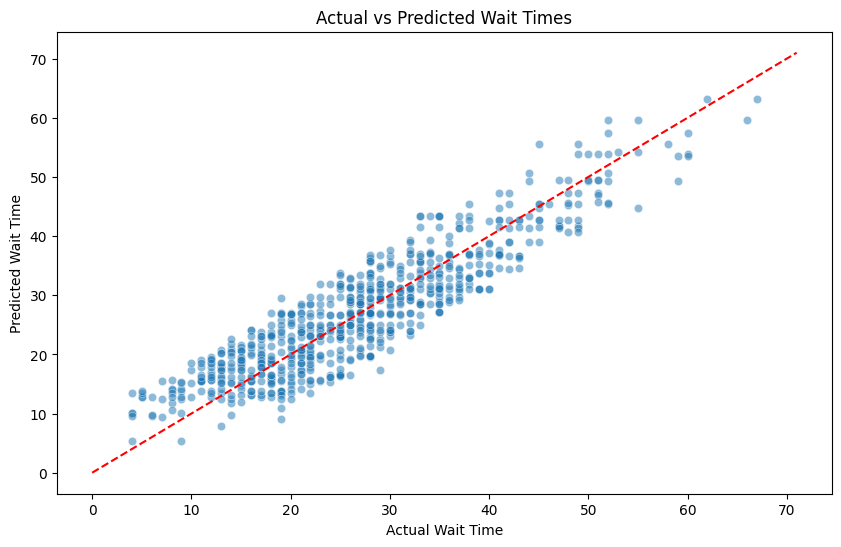

Model saved to models/wait_time_model.pkl


In [15]:
# --- VISUALIZE PREDICTIONS VS ACTUAL ---
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_test, y=y_pred, alpha=0.5)
plt.plot([0, y.max()], [0, y.max()], 'r--') # Perfect prediction line
plt.xlabel("Actual Wait Time")
plt.ylabel("Predicted Wait Time")
plt.title("Actual vs Predicted Wait Times")
plt.show()

# --- SAVE THE MODEL ---
os.makedirs('../models', exist_ok=True)

# We save the WHOLE pipeline. 
# This means the app doesn't need to know how to do OneHotEncoding.
joblib.dump(model_pipeline, '../models/wait_time_model.pkl')

print("Model saved to models/wait_time_model.pkl")